# Chapter 1: Algorithms and Inference

In [1]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind, t
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings

warnings.filterwarnings("ignore")

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (20, 15)

### 1.1: A Regression Example

##### Data

In [3]:
url = "https://web.stanford.edu/~hastie/CASI_files/DATA/kidney.txt"
df = pd.read_csv(url, header=0, sep=' ')
df.head(4)

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30


In [4]:
# prediction data
df_predict = pd.DataFrame({'age': [20, 30, 40, 50, 60, 70, 80]})

##### Linear Regression

In [5]:
lm = ols(formula='tot ~ age', data=df).fit()
df['lm_fitted'] = lm.fittedvalues.values
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    tot   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     75.31
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           5.18e-15
Time:                        20:33:38   Log-Likelihood:                -314.14
No. Observations:                 157   AIC:                             632.3
Df Residuals:                     155   BIC:                             638.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8600      0.360      7.954      0.0

In [6]:
lm_pred = lm.get_prediction(df_predict).summary_frame()
df_predict['lm_preds'] = lm_pred['mean']
df_predict['lm_se'] = lm_pred['mean_se']

In [7]:
lm_intervals = LineCollection([
    [[age, pred - 2 * se], [age, pred + 2 * se]] 
    for age, pred, se in zip(
        df_predict['age'], df_predict['lm_preds'], df_predict['lm_se']
    )
], color='black', linewidths=4)

Text(0, 0.5, 'Tot')

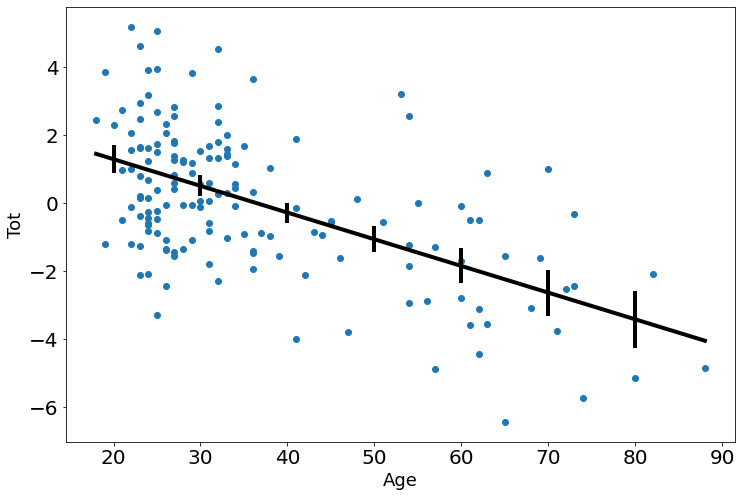

In [8]:
# plot the +/- 2 * standard error lines

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(df.age, df.tot)
ax.plot(df.age, df.lm_fitted, c='k', lw=4)  
ax.add_collection(lm_intervals)
    
ax.set_xlabel('Age', size=18)
ax.set_ylabel('Tot', size=18)

##### Lowess Regression

In [9]:
loess = lowess(df.tot, df.age, frac=1/3.)

In [10]:
it = 0
n = df.shape[0]
B = 1000

boots = []
while it < B:
    indices = np.random.choice(np.array(range(n)), size=n, replace=True)
    dfnew = df.iloc[indices]
    preds = lowess(dfnew.tot, dfnew.age, frac=1/3.)
    
    # nan values are possible depending on the resampling
    if np.isnan(preds).sum() == 0:
        boots.append(preds)
        it += 1
    else:
        pass
    
boots[0][:5]

array([[18.        ,  2.37504459],
       [20.        ,  1.74465524],
       [21.        ,  1.45313506],
       [22.        ,  1.17669067],
       [22.        ,  1.17669067]])

In [11]:
# interpolate ages from original model
interpolate = interp1d(
    loess[:, 0], loess[:, 1], 
    fill_value="extrapolate", assume_sorted=True
)

# interpolate ages from bootstrapped models to create standard error
preds_matrix = np.zeros((df_predict.shape[0], B))
for i, pred in enumerate(boots):
    pred = np.unique(pred, axis=0)
    interpolate_boot = interp1d(
        pred[:, 0], pred[:, 1], 
        fill_value="extrapolate", assume_sorted=True
    )
    preds_matrix[:, i] = interpolate_boot(df_predict['age'])
    
# add to dataframe
df_predict['loess_preds'] = interpolate(df_predict['age'])
df_predict['loess_se'] = np.std(preds_matrix, axis=1, ddof=1)

In [12]:
loess_intervals = LineCollection([
    [[age, pred - 2 * se], [age, pred + 2 * se]] 
    for age, pred, se in zip(
        df_predict['age'], df_predict['loess_preds'], df_predict['loess_se']
    )
], color='black', linewidths=4)

Text(0, 0.5, 'Tot')

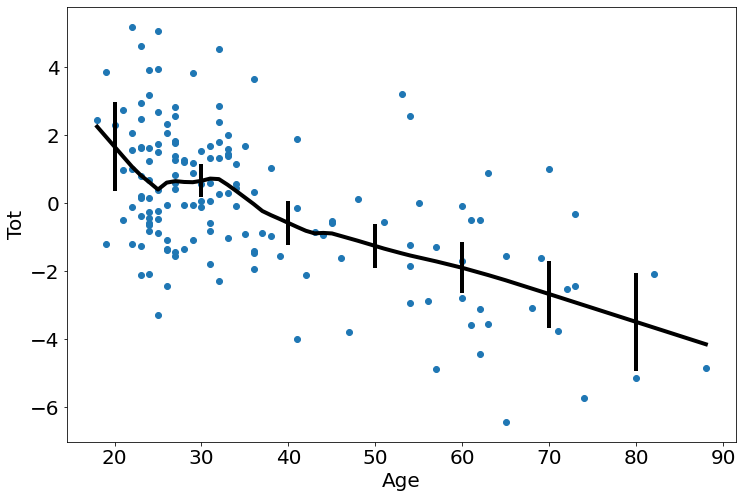

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(df.age, df.tot)
ax.plot(loess[:, 0], loess[:, 1], c='k', lw=4)  
ax.add_collection(loess_intervals)
    
ax.set_xlabel('Age')
ax.set_ylabel('Tot')

Text(0, 0.5, 'Tot')

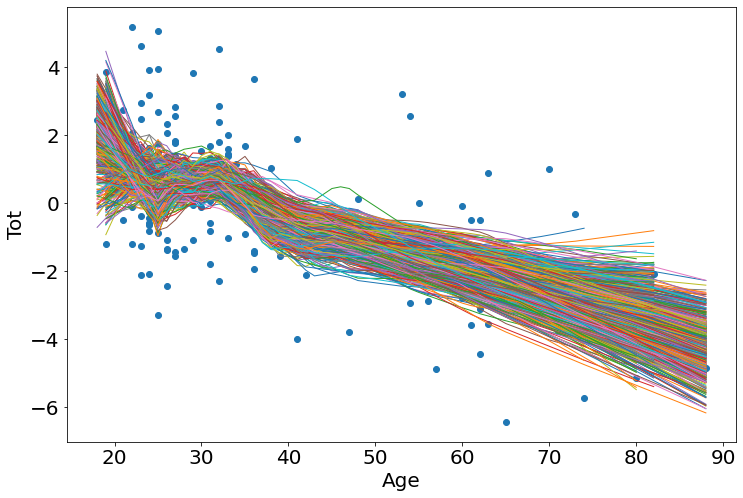

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(df.age, df.tot)

for i in boots:
    ax.plot(i[:, 0], i[:, 1], lw=1)
    
ax.set_xlabel('Age')
ax.set_ylabel('Tot')

##### Comparison

In [15]:
df_predict

,age,lm_preds,lm_se,loess_preds,loess_se
0,20,1.288258,0.206648,1.657627,0.656174
1,30,0.502374,0.154965,0.652812,0.243825
2,40,-0.283510,0.147398,-0.589724,0.317099
3,50,-1.069394,0.189314,-1.267585,0.322888
4,60,-1.855278,0.257595,-1.910113,0.375976
5,70,-2.641162,0.336559,-2.683480,0.494588
6,80,-3.427046,0.420226,-3.499124,0.718586


In [16]:
tmplt = " {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f}"
print("                                           age")
print("                          --------------------------------------")
print("                          20    30    40    50    60    70    80")
print("-" * 64)
print("1. linear regression  " + tmplt.format(*df_predict['lm_preds']))
print("2. std error          " + tmplt.format(*df_predict['lm_se']))
print("")
print("3. lowess regression  " + tmplt.format(*df_predict['loess_preds']))
print("4. boostrap std error " + tmplt.format(*df_predict['loess_se']))

                                           age
                          --------------------------------------
                          20    30    40    50    60    70    80
----------------------------------------------------------------
1. linear regression    1.29  0.50 -0.28 -1.07 -1.86 -2.64 -3.43
2. std error            0.21  0.15  0.15  0.19  0.26  0.34  0.42

3. lowess regression    1.66  0.65 -0.59 -1.27 -1.91 -2.68 -3.50
4. boostrap std error   0.66  0.24  0.32  0.32  0.38  0.49  0.72


### 1.2: Hypothesis Testing

In [17]:
df2 = pd.read_csv('./data/leukemia_big.csv', header=0)
df2.head(4)

,ALL,ALL.1,ALL.2,ALL.3,ALL.4,ALL.5,ALL.6,ALL.7,ALL.8,ALL.9,...,AML.15,AML.16,AML.17,AML.18,AML.19,AML.20,AML.21,AML.22,AML.23,AML.24
0,-1.533622,-0.867610,-0.433172,-1.671903,-1.187689,-1.127234,-1.045409,-0.106917,-1.198796,-1.190899,...,-0.436650,-1.274708,-0.681458,-0.876610,-0.624022,-0.431628,-1.435259,-0.671954,-1.013161,-0.969482
1,-1.235673,-1.275501,-1.184492,-1.596424,-1.335256,-1.113730,-0.800880,-0.745177,-0.849312,-1.190899,...,-0.915483,-1.354363,-0.653559,-1.096250,-1.066594,-1.335256,-1.204586,-0.751457,-0.889592,-1.080988
2,-0.333983,0.375927,-0.459196,-1.422571,-0.797493,-1.362768,-0.671954,-1.175674,0.320813,0.646610,...,-0.736156,-0.022153,-0.037455,-0.567335,-1.100749,-0.552938,-0.948874,-0.231657,-0.742163,-0.779500
3,0.488702,0.444011,0.436264,0.193353,0.235632,-0.360312,0.184941,0.425653,0.333983,0.235270,...,0.083781,0.356562,0.416241,0.533986,0.227505,0.416816,0.408202,0.326556,0.361813,0.298864


In [18]:
df2_all = df2[[c for c in df2.columns if c.startswith('ALL')]]
df2_aml = df2[[c for c in df2.columns if c.startswith('AML')]]

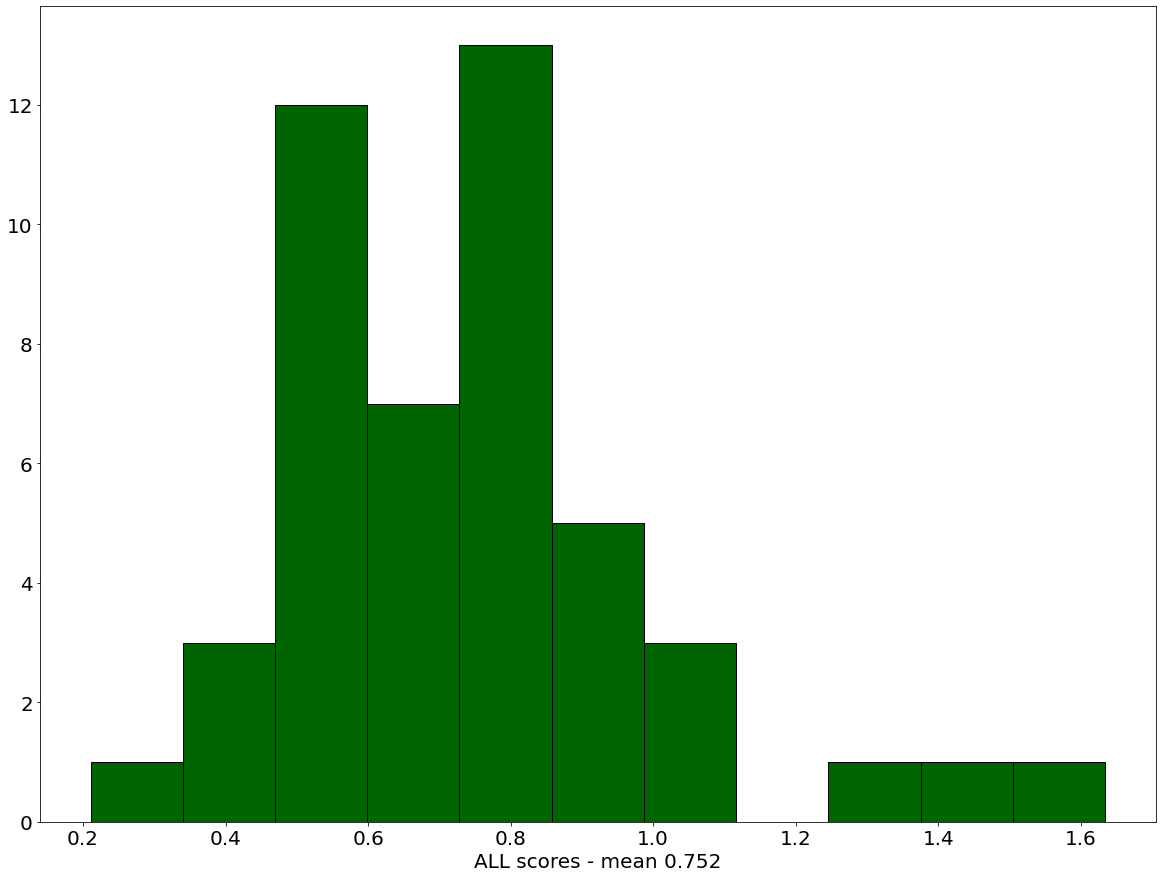

In [19]:
# histogram - ALL
all136 = df2_all.iloc[135].values
n_all = len(all136)
mean_all = np.mean(all136)
plt.hist(all136, bins=11, color='darkgreen', edgecolor='black')
plt.xlabel('ALL scores - mean {}'.format(np.round(mean_all, 3)))
plt.show()

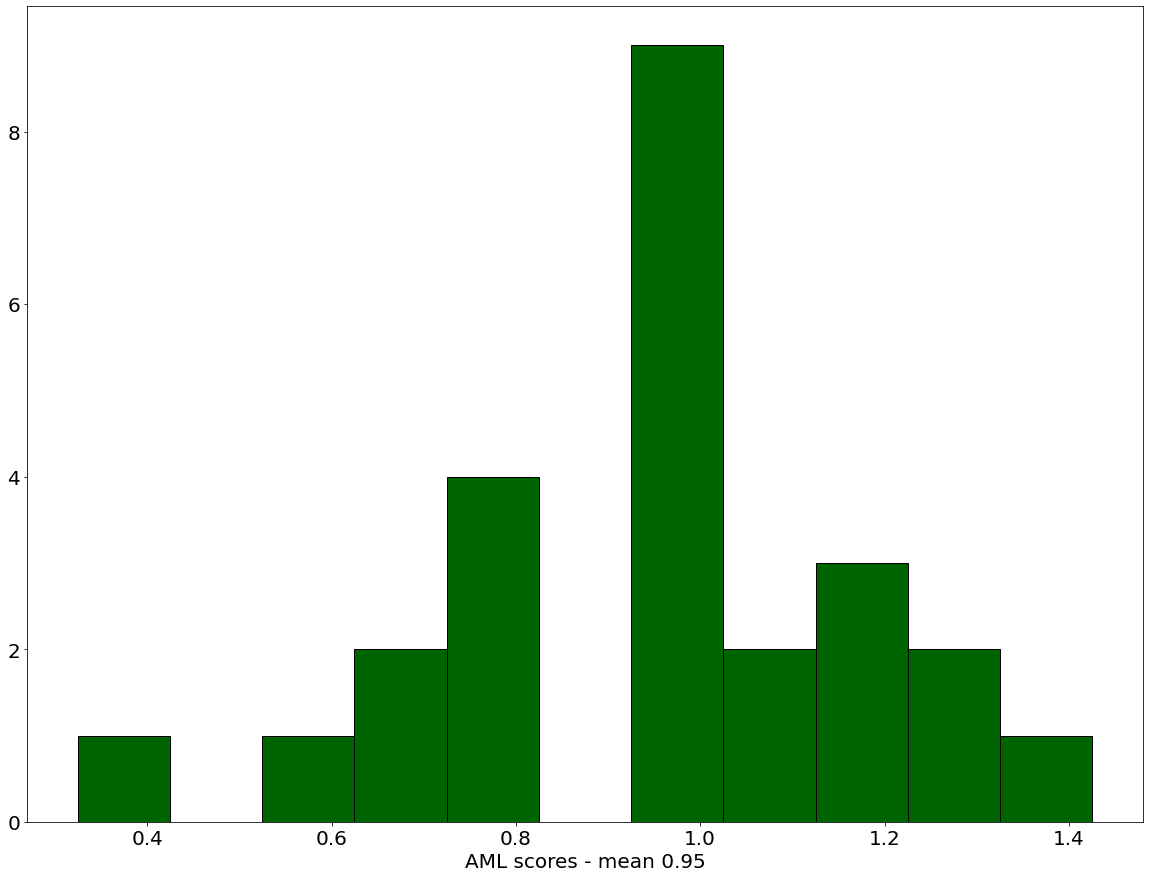

In [20]:
# histogram - AML
aml136 = df2_aml.iloc[135].values
n_aml = len(aml136)
mean_aml = np.mean(aml136)
plt.hist(aml136, bins=11, color='darkgreen', edgecolor='black')
plt.xlabel('AML scores - mean {}'.format(np.round(mean_aml, 3)))
plt.show()

In [21]:
# t-statistic
numer = mean_aml - mean_all
denom = (
    np.sqrt(
        ((n_aml - 1) * np.var(aml136, ddof=1) + 
         (n_all - 1) * np.var(all136, ddof=1)) / (n_aml + n_all - 2)
    ) * 
    np.sqrt((1 / n_aml) + (1 / n_all))
)
t_stat = numer / denom

# critical value
alpha = 0.05
crit_val = t.ppf(1.0 - alpha, df=(n_aml + n_all - 2))

# p-value
p_val = 2 * (1 - t.cdf(x=abs(t_stat), df=(n_aml + n_all - 2)))

# scipy function
t_test = ttest_ind(aml136, all136, equal_var=True)

print('''
    Method: From Scratch
    - T-statistic: {tstat_scratch}
    - P-value: {pval_scratch}
    
    Method: Scipy
    - T-statistic: {tstat_scipy}
    - P-value: {pval_scipy}
'''.format(
    tstat_scratch=round(t_stat, 2),
    pval_scratch=round(p_val, 4),
    tstat_scipy=round(t_test[0], 2),
    pval_scipy=round(t_test[1], 4)
))


    Method: From Scratch
    - T-statistic: 3.01
    - P-value: 0.0036
    
    Method: Scipy
    - T-statistic: 3.01
    - P-value: 0.0036



In [22]:
list_t_stats = []
for i in range(df2.shape[0]):
    v_aml = df2_aml.iloc[i].values
    v_all = df2_all.iloc[i].values
    t_test = ttest_ind(v_aml, v_all, equal_var=True)
    list_t_stats.append(t_test[0])

In [23]:
# count and percent of genes with t-statistic greater than gene 136 (above)
count = np.sum([1 if i > round(t_stat, 2) else 0 for i in list_t_stats])
percent = count / len(list_t_stats)
print('''
    Gene t-statistics greater than gene 136 ({t_stat_136}):
    - Count = {count}
    - Percent = {percent}%
'''.format(
    t_stat_136=round(t_stat, 2), 
    count=count, 
    percent=100 * round(percent, 4)
))


    Gene t-statistics greater than gene 136 (3.01):
    - Count = 416
    - Percent = 5.84%



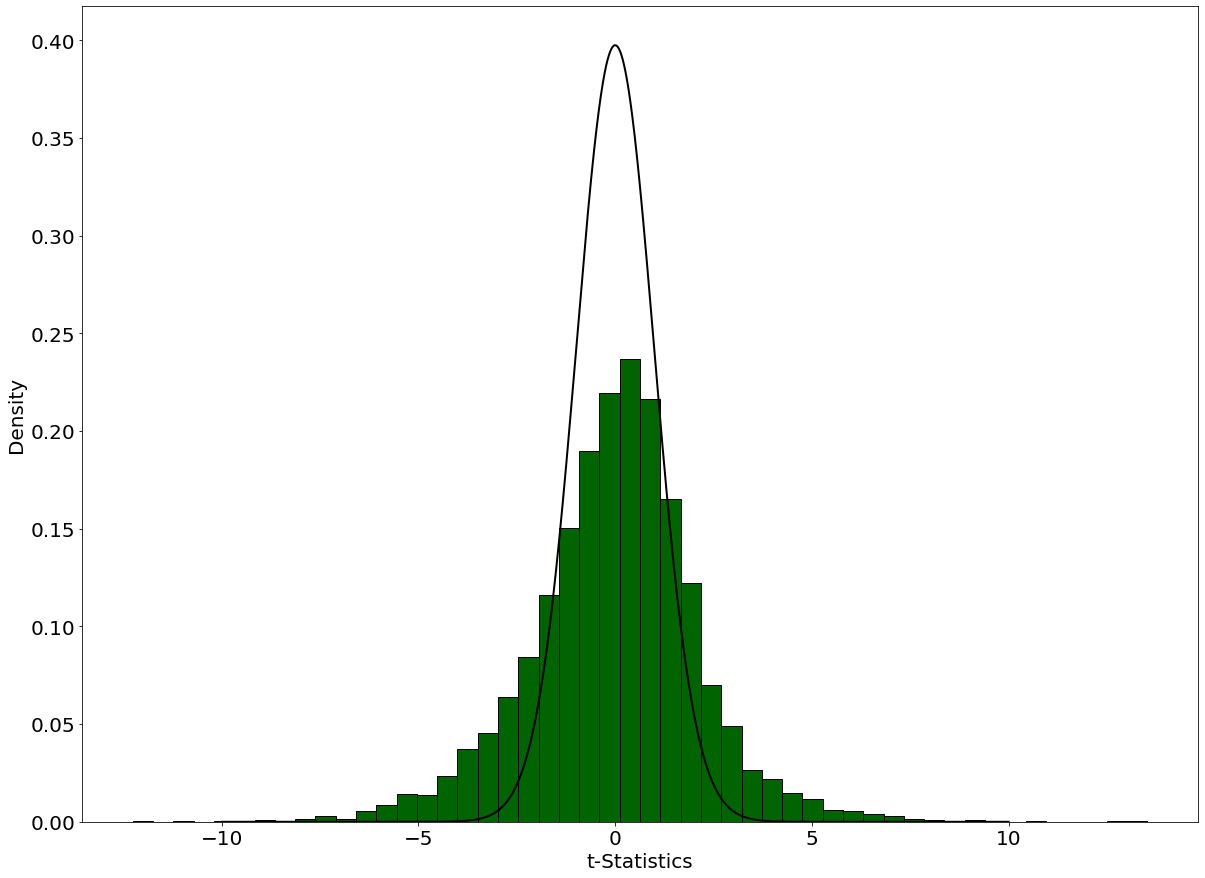

In [24]:
x = np.linspace(-10, 10, 5000)
y_pdf = t.pdf(x, df=(n_aml + n_all - 2))

plt.hist(list_t_stats, bins=50, density=True, color='darkgreen', edgecolor='black')
plt.plot(x, y_pdf, c='k', lw=2)
plt.xlabel('t-Statistics')
plt.ylabel('Density')
plt.show()